# Bài toán "Start Date to End Date"

## Vấn đề của bài toán

Cần phải tính toán tại **1 thời điểm cụ thể** *(năm, tháng, ngày, giờ,... nào đó)* có bao nhiêu người/vật có mặt.

VD: 
- Vào ngày xx/xx/xxxx có bao nhiêu sản phẩm đang lưu kho (lưu ý mỗi sản phẩm có thời gian lưu kho và xuất kho khác nhau)?
- Vào ngày xx/xx/xxxx có bao nhiêu nhân viên đang được chỉ định vào làm việc cho một dự án nào đó?

Tuy nhiên, khoảng thời gian từ **ngày bắt đầu** đến **ngày kết thúc** của mỗi người/vật là khác nhau.

In [4]:
import numpy as np
import pandas as pd
import re

In [5]:
# Get data path & data name
data_path = 'D:\\DA\\PhantichdulieuPython\\data\\'
data_name = 'erd_demo.xlsx'

In [6]:
allocated_sheet_name = 'allocated'
employee_sheet_name = 'emp_info'
customer_sheet_name = 'cus_info'

In [37]:
# Load allocated data to Pandas object
allc = pd.read_excel(data_path + data_name
                     ,sheet_name = allocated_sheet_name)
allc.head()

,emp_id,allocated_from,allocated_to,customer_code
0,ductt,2023-02-15,2023-04-30,git
1,manhdt1,2023-02-01,2023-07-04,sld
2,khoand26,2023-04-12,2023-04-30,sld
3,lanntt,2023-03-15,2023-06-15,git
4,anhntt21,2023-07-01,2023-09-30,bii


Như ví dụ này, mỗi nhân viên được chỉ định làm việc cho một khách hàng cụ thể từ ngày bao nhiêu tới ngày bao nhiêu.

Do đó trong cùng 1 ngày, có các trường hợp sau đây:
1. Không có nhân viên nào đang được chỉ định
2. Có 1 nhân viên đang được chỉ định làm việc cho 1 khách hàng cụ thể
3. Có nhiều nhân viên đang được chỉ định làm việc cho nhiều khách hàng khác nhau

Trường hợp 2 và 3 được gom lại thành 1 nhóm (1 hoặc nhiều). Và chúng ta chỉ đang có data của nhóm này thôi.
Do đó, việc cần làm lúc này là tạo ra 1 list các ngày từ đầu năm đến cuối năm, và trong đó phân biệt rõ ngày nào ở trường hợp 1, ngày nào ở trường hợp 2 và 3.

Kiểm tra values duplicate
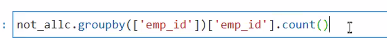

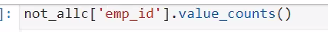

In [38]:
not_allc['emp_id'].value_counts()

emp_id
longtt      275
manhdt1     154
lanntt       93
anhntt21     92
ductt        75
lamd6        61
hoattt       61
nhansm3      30
khoand26     19
Name: count, dtype: int64

In [39]:
not_allc.groupby(['emp_id'])['emp_id'].count()

emp_id
anhntt21     92
ductt        75
hoattt       61
khoand26     19
lamd6        61
lanntt       93
longtt      275
manhdt1     154
nhansm3      30
Name: emp_id, dtype: int64

In [40]:
not_allc = allc.loc[:,['emp_id']]
not_allc.head()

,emp_id
0,ductt
1,manhdt1
2,khoand26
3,lanntt
4,anhntt21


In [41]:
not_allc.drop_duplicates(inplace = True) #drop những giá trị trùng

#hoặc not_allc = not_allc.drop_duplicates(inplace = True)
not_allc

,emp_id
0,ductt
1,manhdt1
2,khoand26
3,lanntt
4,anhntt21
5,nhansm3
6,longtt
7,lamd6
8,hoattt


In [42]:
not_allc.shape

(9, 1)

In [43]:
#lấy giá trị của dòng cuối
not_allc.shape[0]

9

In [44]:
not_allc['all_2023_date'] = [pd.date_range(start = '1/1/2023', end = '12/31/2023').tolist()\
                             for _ in range(not_allc.shape[0])]
not_allc.head()

,emp_id,all_2023_date
0,ductt,"[2023-01-01 00:00:00, 2023-01-02 00:00:00, 202..."
1,manhdt1,"[2023-01-01 00:00:00, 2023-01-02 00:00:00, 202..."
2,khoand26,"[2023-01-01 00:00:00, 2023-01-02 00:00:00, 202..."
3,lanntt,"[2023-01-01 00:00:00, 2023-01-02 00:00:00, 202..."
4,anhntt21,"[2023-01-01 00:00:00, 2023-01-02 00:00:00, 202..."


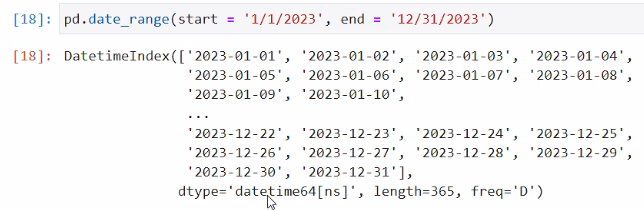

In [45]:
#expand dữ liệu từ list ra từng dòng 
not_allc = not_allc.explode('all_2023_date')

In [46]:
not_allc.head()

,emp_id,all_2023_date
0,ductt,2023-01-01
0,ductt,2023-01-02
0,ductt,2023-01-03
0,ductt,2023-01-04
0,ductt,2023-01-05


In [15]:
not_allc.shape

# 9 nhân viên nhân 365 ngày -> 3285 dòng, 2 cột

(3285, 2)

Kết quả, chúng ta đã có 1 danh sách 365 ngày cho từng nhân viên. Những ngày này đang được mặc định là "chưa có việc".

Việc tiếp theo là chúng ta tìm danh sách những ngày mà 1 nhân viên nào đó "đang có việc". Bằng cách tạo 1 danh sách những ngày từ **Ngày bắt đầu** đến **Ngày kết thúc** công việc.

In [16]:
allc.dtypes

emp_id                    object
allocated_from    datetime64[ns]
allocated_to      datetime64[ns]
customer_code             object
dtype: object

In [48]:
#Lấy scalar ở vị trí 0
allc['allocated_from'][0]

Timestamp('2023-02-15 00:00:00')

In [50]:
# range từ from...to
pd.date_range(allc['allocated_from'][0], allc['allocated_to'][0])

DatetimeIndex(['2023-02-15', '2023-02-16', '2023-02-17', '2023-02-18',
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03', '2023-03-04', '2023-03-05', '2023-03-06',
               '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
               '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14',
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18',
               '2023-03-19', '2023-03-20', '2023-03-21', '2023-03-22',
               '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26',
               '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
               '2023-03-31', '2023-04-01', '2023-04-02', '2023-04-03',
               '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-07',
               '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11',
      

In [52]:
allc['allocated_range'] = [pd.date_range(allc['allocated_from'][_], allc['allocated_to'][_]).tolist()\
                           for _ in range(allc.shape[0])]

In [53]:
allc.head()

,emp_id,allocated_from,allocated_to,customer_code,allocated_range
0,ductt,2023-02-15,2023-04-30,git,"[2023-02-15 00:00:00, 2023-02-16 00:00:00, 202..."
1,manhdt1,2023-02-01,2023-07-04,sld,"[2023-02-01 00:00:00, 2023-02-02 00:00:00, 202..."
2,khoand26,2023-04-12,2023-04-30,sld,"[2023-04-12 00:00:00, 2023-04-13 00:00:00, 202..."
3,lanntt,2023-03-15,2023-06-15,git,"[2023-03-15 00:00:00, 2023-03-16 00:00:00, 202..."
4,anhntt21,2023-07-01,2023-09-30,bii,"[2023-07-01 00:00:00, 2023-07-02 00:00:00, 202..."


In [19]:
allc = allc.explode('allocated_range')

In [20]:
allc

,emp_id,allocated_from,allocated_to,customer_code,allocated_range
0,ductt,2023-02-15,2023-04-30,git,2023-02-15
0,ductt,2023-02-15,2023-04-30,git,2023-02-16
0,ductt,2023-02-15,2023-04-30,git,2023-02-17
0,ductt,2023-02-15,2023-04-30,git,2023-02-18
0,ductt,2023-02-15,2023-04-30,git,2023-02-19
...,...,...,...,...,...
8,hoattt,2023-05-01,2023-06-30,sld,2023-06-26
8,hoattt,2023-05-01,2023-06-30,sld,2023-06-27
8,hoattt,2023-05-01,2023-06-30,sld,2023-06-28
8,hoattt,2023-05-01,2023-06-30,sld,2023-06-29


In [56]:
allc.dtypes

emp_id                     object
allocated_from     datetime64[ns]
allocated_to       datetime64[ns]
customer_code              object
allocated_range            object
status                     object
dtype: object

Sau khi hoàn thành danh sách, chúng ta thêm cột mới để đánh dấu trạng thái **Đang có việc (Allocated)** của nhân viên đó.

In [57]:
allc['status'] = 'Allocated'


In [58]:
allc.head()

,emp_id,allocated_from,allocated_to,customer_code,allocated_range,status
0,ductt,2023-02-15,2023-04-30,git,"[2023-02-15 00:00:00, 2023-02-16 00:00:00, 202...",Allocated
1,manhdt1,2023-02-01,2023-07-04,sld,"[2023-02-01 00:00:00, 2023-02-02 00:00:00, 202...",Allocated
2,khoand26,2023-04-12,2023-04-30,sld,"[2023-04-12 00:00:00, 2023-04-13 00:00:00, 202...",Allocated
3,lanntt,2023-03-15,2023-06-15,git,"[2023-03-15 00:00:00, 2023-03-16 00:00:00, 202...",Allocated
4,anhntt21,2023-07-01,2023-09-30,bii,"[2023-07-01 00:00:00, 2023-07-02 00:00:00, 202...",Allocated


Cuối cùng, chúng ta **join** danh sách những ngày Đang có việc vào danh sách 365 ngày, sẽ tìm ra được những ngày trống việc.

In [24]:
status_by_day = pd.merge(not_allc, allc
                         , how = 'left'
                         , left_on = ['emp_id', 'all_2023_date']
                         , right_on = ['emp_id', 'allocated_range'])
status_by_day.head()

,emp_id,all_2023_date,allocated_from,allocated_to,customer_code,allocated_range,status
0,ductt,2023-01-01,NaT,NaT,NaN,NaT,NaN
1,ductt,2023-01-02,NaT,NaT,NaN,NaT,NaN
2,ductt,2023-01-03,NaT,NaT,NaN,NaT,NaN
3,ductt,2023-01-04,NaT,NaT,NaN,NaT,NaN
4,ductt,2023-01-05,NaT,NaT,NaN,NaT,NaN


In [60]:
status_by_day['month'] = status_by_day['all_2023_date'].dt.month


In [61]:
status_by_day.groupby(['month', 'status'])['emp_id'].nunique()

month  status   
2      Allocated    2
3      Allocated    4
4      Allocated    7
5      Allocated    4
6      Allocated    4
7      Allocated    3
8      Allocated    2
9      Allocated    2
10     Allocated    1
11     Allocated    1
12     Allocated    1
Name: emp_id, dtype: int64

In [62]:
status_by_day.groupby(['month', 'status'])['customer_code'].unique().reset_index()

,month,status,customer_code
0,2,Allocated,"[git, sld]"
1,3,Allocated,"[git, sld, ggt]"
2,4,Allocated,"[git, sld, bii, tlt, ggt]"
3,5,Allocated,"[sld, git, tlt]"
4,6,Allocated,"[sld, git, tlt]"
5,7,Allocated,"[sld, bii, tlt]"
6,8,Allocated,"[bii, tlt]"
7,9,Allocated,"[bii, tlt]"
8,10,Allocated,[tlt]
9,11,Allocated,[tlt]


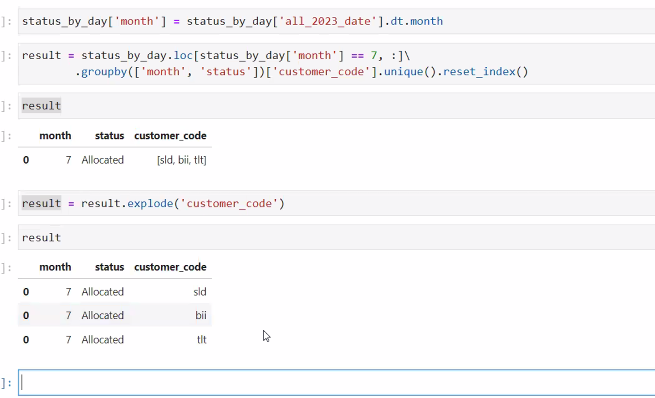

In [63]:
status_by_day['month'] = status_by_day['all_2023_date'].dt.month

In [65]:
result = status_by_day.loc[status_by_day['month'] == 7, :].groupby(['month','status'])['customer_code'].unique().reset_index()

In [66]:
result

,month,status,customer_code
0,7,Allocated,"[sld, bii, tlt]"


In [70]:
result = result.explode('customer_code')
result

,month,status,customer_code
0,7,Allocated,sld
0,7,Allocated,bii
0,7,Allocated,tlt


In [72]:
# Load allocated data to Pandas object
cus = pd.read_excel(data_path + data_name
                     ,sheet_name = customer_sheet_name)
cus.head()

,code,name
0,git,Game for IT
1,sld,Slow Down
2,bii,Biotechnology Information Institute
3,tlt,Transmission Line
4,ggt,Gamma-GT


In [73]:
#Lây cutsomer nam
pd.merge(result, cus, how = 'inner', left_on = ['customer_code'], right_on = 'code')

,month,status,customer_code,code,name
0,7,Allocated,sld,sld,Slow Down
1,7,Allocated,bii,bii,Biotechnology Information Institute
2,7,Allocated,tlt,tlt,Transmission Line


In [75]:
#Lây cutsomer nam
pd.merge(result, cus, how = 'inner', left_on = ['customer_code'], right_on = 'code')['name'].tolist()

['Slow Down', 'Biotechnology Information Institute', 'Transmission Line\xa0']

In [ ]:
#site HCM được Allocated trong những tháng nào?